In [64]:
import os
import re

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from scipy.fft import fft2
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams.update({'font.size':14, 'savefig.facecolor':'w'})

In [108]:
folder = 'tmp_chain2_cs2_0.33_re_1.00_nu_0.30_u_0.03_tau_1.40_cy_20.00_W_41_N_16_rad2_10.0_inter_4.0R/'
# folder = 'tmp_chain2_cs2_0.33_re_1.00_nu_0.30_u_0.03_tau_1.40_cy_60.56_W_81_N_16_rad2_10.0_inter_4.0R/'
folder_pics = 'pics/'

files = [f for f in os.listdir(folder) if f.endswith('txt') and 'copy' not in f and f.startswith('disk')]
W = int(re.findall('_W_([0-9]*)', folder)[0]) - 1
uflow = float(re.findall('u_([0-9]{1}[.][0-9]{2})_', folder)[0])
reynolds = float(re.findall('re_([0-9]{1}[.][0-9]{2})_', folder)[0])
cs2 = float(re.findall('cs2_([0-9]{1}[.][0-9]{2})_', folder)[0])
if 'rad2' in folder:
    rad2 = float(re.findall('rad2_([0-9]{2}[.][0-9]{1})', folder)[0])
else:
    rad2 = 10
    
y0 = float(re.findall('cy_([0-9]{2,3}[.][0-9]{2})', folder)[0])
print(y0)

if 'inter' in folder:
    inter = float(re.findall('inter_([0-9]{1}[.][0-9]{1})', folder)[0])
else:
    inter = 4
    
rad = 10

# folder_pics = f'pics_y_pairs/w_{W}_rad2_{rad2:.1f}/'
if not os.path.exists(folder_pics):
    os.mkdir(folder_pics)
    

N = len(files)
L = inter * rad * N
particles_files = {int(re.findall('_(\d+).t', f)[0]) :f for f in files}
particles_files

20.0


{0: 'disk_re_0.25_0.txt',
 1: 'disk_re_0.25_1.txt',
 10: 'disk_re_0.25_10.txt',
 11: 'disk_re_0.25_11.txt',
 12: 'disk_re_0.25_12.txt',
 13: 'disk_re_0.25_13.txt',
 14: 'disk_re_0.25_14.txt',
 15: 'disk_re_0.25_15.txt',
 2: 'disk_re_0.25_2.txt',
 3: 'disk_re_0.25_3.txt',
 4: 'disk_re_0.25_4.txt',
 5: 'disk_re_0.25_5.txt',
 6: 'disk_re_0.25_6.txt',
 7: 'disk_re_0.25_7.txt',
 8: 'disk_re_0.25_8.txt',
 9: 'disk_re_0.25_9.txt'}

In [109]:
if os.path.exists(folder + 'particles.npy'):
    particles = np.load(folder + 'particles.npy')
else:
    lst = []
    min_time = np.inf
    for file in files:
        print(file, end='\t')
        arr = np.loadtxt(folder + file)
        if arr.shape[0] < min_time:
            min_time = arr.shape[0]
        lst.append(arr)
    #     print(file, end=' ')

    for i, arr in enumerate(lst):
        lst[i] = arr[:min_time]


    particles = np.array(lst)
    particles = particles[np.argsort(particles[:, 0, 1])]
    np.save(folder + 'particles.npy', particles)
    
particles.shape

(16, 878, 11)

In [110]:
v = np.array([[1, 1], [1, 0], [1, -1], [0, 1], [0, 0],\
              [0, -1], [-1, 1], [-1, 0], [-1, -1]])

def macroscopic(fin, v):
    q, nx, ny = fin.shape
    rho = np.sum(fin, axis=0)
    u = np.zeros((2, nx, ny))
    for i in range(q):
        u[0] += v[i, 0] * fin[i]
        u[1] += v[i, 1] * fin[i]
        
    u /= rho
    return rho, u


In [111]:
fin = np.load(folder + 'checkpoint_fin.npy')
q, nx, ny = fin.shape
rho, vel = macroscopic(fin, v)

8000 0.027430717254476943 0.001640414635976705 1.0017280283003596 0.9982510898353789


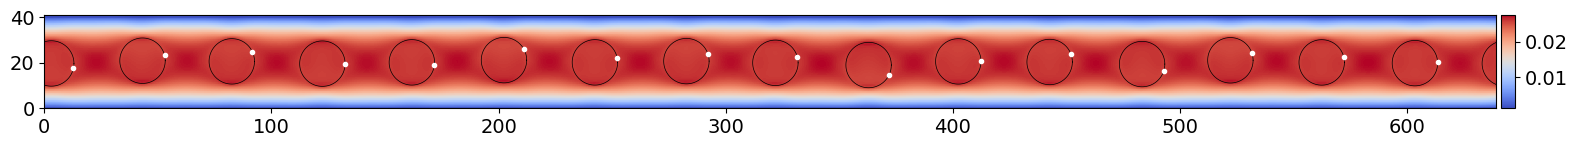

In [115]:
time = int(particles[0, -1, 0] // 8000) * 8000
time_ind = time // 10

fig, ax = plt.subplots(figsize=(16, 2))
unorm = np.sqrt(vel[0] ** 2 + vel[1] ** 2)
print(time, unorm[:, ny//2].max(),
      unorm[:, ny//2].max() - unorm[:, ny//2].min(), 
     rho.max(), rho.min())
c = ax.imshow(unorm.transpose(), cmap=cm.coolwarm)
angles = np.linspace(0, 2 * np.pi, 100, endpoint=True)

for p in range(N):
    cx, cy = particles[p, time_ind, 1], particles[p, time_ind, 2]
    if cx < rad or cx > L - rad:
        ax.plot(cx + rad * np.cos(angles) + L, cy + rad * np.sin(angles), 'k', linewidth=0.5)
        
    ax.plot(cx + rad * np.cos(angles), cy + rad * np.sin(angles), 'k', linewidth=0.5)
    ax.plot(particles[p, time_ind, 3], particles[p, time_ind, 4], '.w')
    
ax.set_xlim([0, nx-1])
ax.set_ylim([0, ny])

ax.set_yticks(np.arange(0, ny, (ny - 1) // 2))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='1%', pad=0.05)

plt.colorbar(c, cax=cax)
fig.tight_layout()
fig.savefig(folder_pics + f'W_{W}_N_{N}.png', dpi=500)


In [101]:
txy1 = particles[:, :, [0, 1, 2, 5, -1]].copy()

In [102]:
txy = txy1.copy()
# mean_y = txy[:, :, 2].mean(axis=0)
# for i in range(N):
#     txy[i, :, 2] -= mean_y

for i in range(N):
    txy[i, :, 1] = (txy1[i, :, 1] - txy1[i-1, :, 1]) + \
             L * np.array(txy1[i, :, 1] < txy1[i - 1, :, 1], dtype=int )
    
for i in range(N):    
    txy[i, :, 3] = (txy1[i, :, 1] - txy1[i-2, :, 1]) + \
             L * np.array(txy1[i, :, 1] < txy1[i - 2, :, 1], dtype=int )


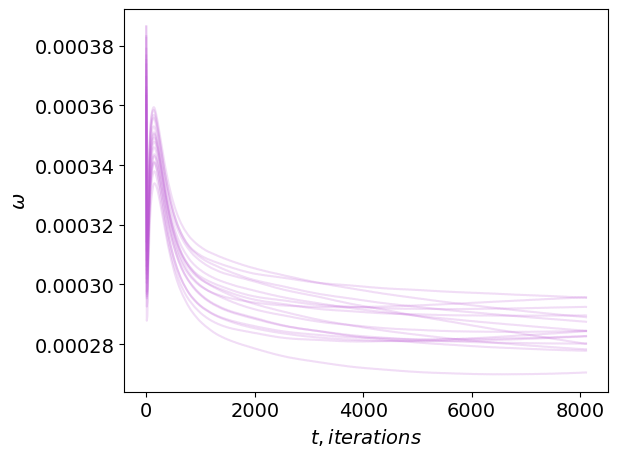

In [103]:
col = ['deepskyblue', 'mediumorchid']
fig, ax = plt.subplots()
rho2 = 1
for i in range(N):
#     ax.plot(txy[i, :, 0], txy[i, :,2], color=col[i%2])
    ax.plot(txy[i, :, 0], txy[i, :, -1], color='mediumorchid', alpha=0.2)

# ax.plot(txy[0, :, 0], txy[::2, :, 2].mean(axis=0), color='deepskyblue', label='even')
# ax.plot(txy[0, :, 0], txy[1::2, :, 2].mean(axis=0), color='salmon', label='odd')

ax.set_xlabel(r'$t, iterations$')
ax.set_ylabel(r'$\omega$')
# ax.set_xlim([0, 0.5e6])

fig.tight_layout()

fig.savefig(folder_pics + f'time_omega_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_inter_{inter:.1f}_rho2_{rho2:.2f}_cs2_{cs2:.2f}_re_{reynolds:.2f}.png', dpi=300)
fig.savefig(folder_pics + f'time_omega_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_inter_{inter:.1f}_rho2_{rho2:.2f}_cs2_{cs2:.2f}_re_{reynolds:.2f}.pdf', dpi=300)
    

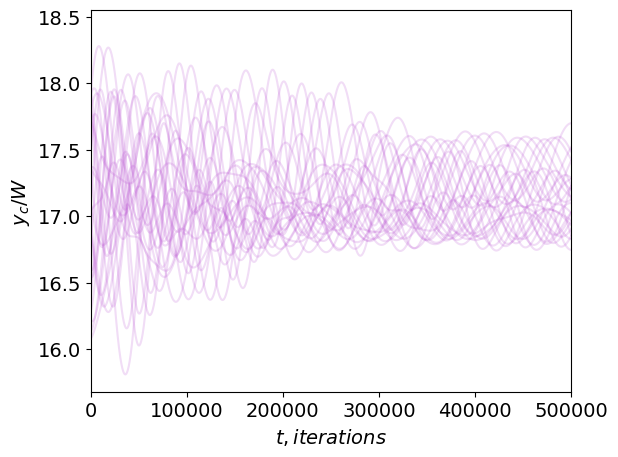

In [10]:
col = ['deepskyblue', 'mediumorchid']
fig, ax = plt.subplots()
rho2 = 1
for i in range(N):
#     ax.plot(txy[i, :, 0], txy[i, :,2], color=col[i%2])
    ax.plot(txy[i, :, 0], txy[i, :, 2], color='mediumorchid', alpha=0.2)

# ax.plot(txy[0, :, 0], txy[::2, :, 2].mean(axis=0), color='deepskyblue', label='even')
# ax.plot(txy[0, :, 0], txy[1::2, :, 2].mean(axis=0), color='salmon', label='odd')

ax.set_xlabel(r'$t, iterations$')
ax.set_ylabel(r'$y_c / W$')
ax.set_xlim([0, 0.5e6])

fig.tight_layout()
if 'rad' not in folder:
    fig.savefig(folder_pics + f'time_y_W_{W}_N_{N}_same_cy_{y0:.2f}_inter_{inter:.1f}_rho2_{rho2:.2f}_cs2_{cs2:.2f}_re_{reynolds:.2f}.png', dpi=300)
    fig.savefig(folder_pics + f'time_y_W_{W}_N_{N}_same_cy_{y0:.2f}_inter_{inter:.1f}_rho2_{rho2:.2f}_cs2_{cs2:.2f}_re_{reynolds:.2f}.pdf', dpi=300)
else:
    fig.savefig(folder_pics + f'time_y_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_inter_{inter:.1f}_rho2_{rho2:.2f}_cs2_{cs2:.2f}_re_{reynolds:.2f}.png', dpi=300)
    fig.savefig(folder_pics + f'time_y_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_inter_{inter:.1f}_rho2_{rho2:.2f}_cs2_{cs2:.2f}_re_{reynolds:.2f}.pdf', dpi=300)
    

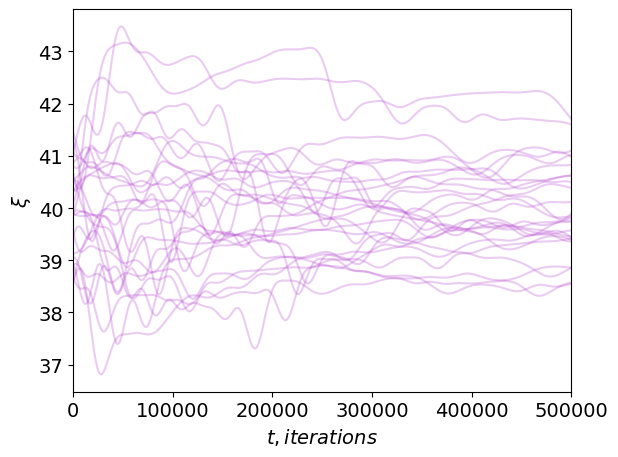

In [12]:
col = ['deepskyblue', 'mediumorchid']
fig, ax = plt.subplots()
for i in range(N):
#     ax.plot(txy[i, :, 0], txy[i, :,2], color=col[i%2])
    ax.plot(txy[i, :50000, 0], txy[i, :50000, 1], color='mediumorchid', alpha=0.3)
    
# ax.plot(txy[0, :, 0], txy[::2, :, 1].mean(axis=0), color='deepskyblue')
# ax.plot(txy[0, :, 0], txy[1::2, :, 1].mean(axis=0), color='salmon')


ax.set_xlabel(r'$t, iterations$')
ax.set_ylabel(r'$\xi$')

ax.set_xlim([0, 5e5])


fig.tight_layout()
if 'rad' not in folder:
    fig.savefig(folder_pics + f'time_xi_W_{W}_N_{N}_same_cy_{y0:.2f}_inter_{inter:.1f}_rho2_{rho2:.2f}_cs2_{cs2:.2f}_re_{reynolds:.2f}.png', dpi=300)
    fig.savefig(folder_pics + f'time_xi_W_{W}_N_{N}_same_cy_{y0:.2f}_inter_{inter:.1f}_rho2_{rho2:.2f}_cs2_{cs2:.2f}_re_{reynolds:.2f}.pdf', dpi=300)
else:
    fig.savefig(folder_pics + f'time_xi_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_inter_{inter:.1f}_rho2_{rho2:.2f}_cs2_{cs2:.2f}_re_{reynolds:.2f}.png', dpi=300)
    fig.savefig(folder_pics + f'time_xi_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_inter_{inter:.1f}_rho2_{rho2:.2f}_cs2_{cs2:.2f}_re_{reynolds:.2f}.pdf', dpi=300)

# vx

In [312]:
%matplotlib notebook

In [8]:
from scipy.fft import fft, fftfreq, fftshift

0.0020106192982974674


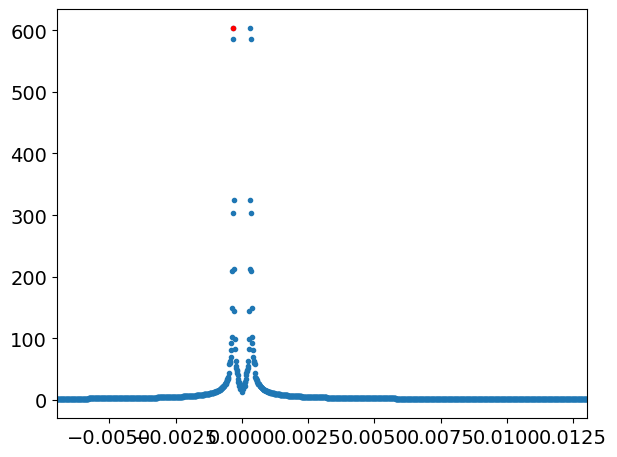

In [39]:
start, end = 0, 75000
y_mean_odd = txy[::2, start:end, 2].mean(axis=0)
y_mean = txy[:, start:end, 2].mean(axis=0)

a = fft(y_mean_odd- y_mean)
freq = fftfreq(y_mean_odd.shape[0])
freq = fftshift(freq)

a = np.abs(fftshift(a))

plt.plot(freq, a, '.')

ind = np.argmax(a)

plt.plot(freq[ind], a[ind], '.', color='r')
plt.xlim(freq[ind-500], freq[ind+1000])
max_freq = np.abs(freq[ind] * 2 * np.pi)
plt.gcf().tight_layout()
print(max_freq)

In [13]:
1 / freq[ind] * txy[:, :, -1].mean(), txy[:, :, -1].mean()

(-55.0660743767722, 0.0176211438005671)

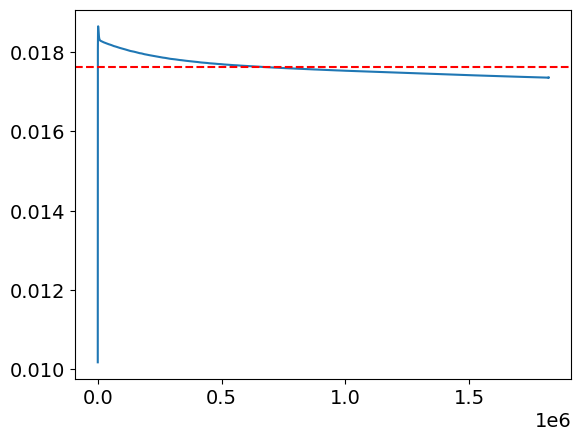

In [14]:
plt.plot(txy[0, :, 0], txy[:, :, -1].mean(axis=0))
plt.gca().axhline(txy[:, :, -1].mean(), color='r', linestyle='--')

(0.0, 75000.0)

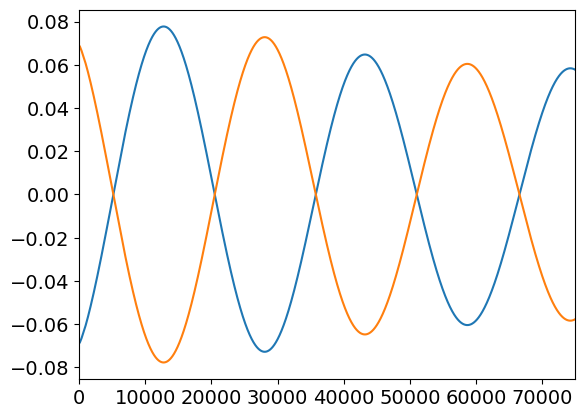

In [18]:
y_mean_odd = txy[1::2, :, 2].mean(axis=0)
y_mean_even = txy[::2, :, 2].mean(axis=0)

y_mean = txy[:, :, 2].mean(axis=0)

plt.plot(txy[0, :, 0], y_mean_odd - y_mean)
plt.plot(txy[0, :, 0], y_mean_even - y_mean)
# plt.plot(txy[0, :, 0], txy[4, :, 2] - y_mean)
plt.xlim([0, 75000])

# Y

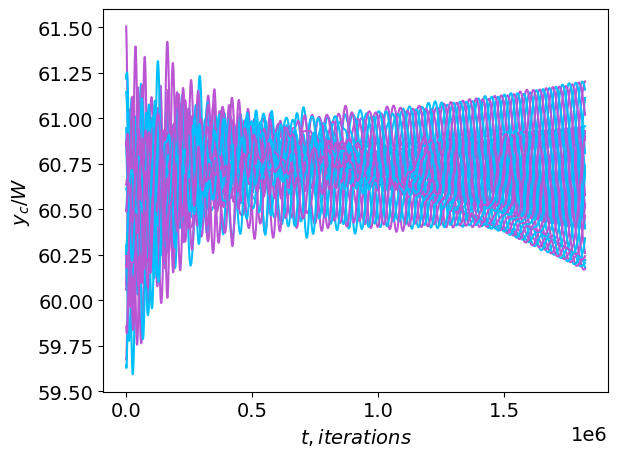

In [19]:
col = ['deepskyblue', 'mediumorchid']
fig, ax = plt.subplots()
for i in range(N):
#     ax.plot(txy[i, :, 0], txy[i, :,2], color=col[i%2])
    ax.plot(txy[i, ::10, 0], txy[i, ::10,2], col[i%2] )

# ax.plot(txy[0, :, 0], mean, 'k', linestyle='--', label='mean y')

# plt.legend(ncol=4)

ax.set_xlabel(r'$t, iterations$')
ax.set_ylabel(r'$y_c / W$')


fig.tight_layout()
if 'rad' not in folder:
    fig.savefig(folder_pics + f'time_y_W_{W}_N_{N}_same_cy_{y0:.2f}_inter_{inter:.1f}_cs2_{cs2:.2f}_re_{reynolds:.2f}.png', dpi=300)
    fig.savefig(folder_pics + f'time_y_W_{W}_N_{N}_same_cy_{y0:.2f}_inter_{inter:.1f}_cs2_{cs2:.2f}_re_{reynolds:.2f}.pdf', dpi=300)
else:
    fig.savefig(folder_pics + f'time_y_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_inter_{inter:.1f}_cs2_{cs2:.2f}_re_{reynolds:.2f}.png', dpi=300)
    fig.savefig(folder_pics + f'time_y_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_inter_{inter:.1f}_cs2_{cs2:.2f}_re_{reynolds:.2f}.pdf', dpi=300)
    

# y

In [20]:
txy.shape

(26, 182139, 5)

In [29]:
start, ind = 0, 75000
# start, ind = 600000, txy.shape[1]

out = fft2(txy[:, start:ind, 2])
out = np.log(np.abs(out)**2 / N**2)
N = out.shape[0]
Nf = out.shape[1]
fft_shape = 30
out2 = np.hstack((out[:,:fft_shape], out[:,-fft_shape:]))
# if num_particles >= 4:
#     out2[0] = np.nan
out2[0,:] = np.nan
out2[:,0] = np.nan
out2[0, 0] = np.nan
s1 = out2.shape[0]/2
s2 = out2.shape[1]//2



out2 = np.roll(out2, shift=int(s1), axis=0)
out2 = np.roll(out2, shift=s2, axis=1)

out2 = get_spectrum(txy, 2, 2, end, 60)
out2 = np.log(out2 / N ** 2)
min_y, max_y = np.nanmin(out2), np.nanmax(out2)

-60 -59 -58 -57 -56 -55 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 

In [41]:
s2 * 2 * np.pi / Nf, max_freq

(0.0025132741228718345, 0.0020106192982974674)

18.387073502884004


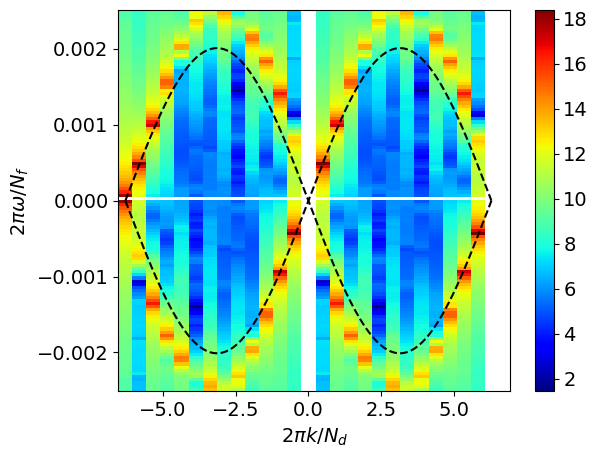

In [42]:
plt.imshow(out2, origin='lower', aspect='auto', cmap='jet', 
#           vmin=min_y, vmax=max_y,
       extent=(-4 * np.pi * (s1 + 0.5)/ N, 
               4 * np.pi * (s1 - 0.5) / N, 
               -2 * np.pi * s2 / Nf,
               2 * np.pi * s2 / Nf))

print(np.nanmax(out2))
#plt.pcolormesh( out2, cmap='jet')

# for i in range(N):
#     try:
#         plt.plot(-2 * np.pi * (i - s1 + 0.5) / N, 2 * np.pi * (-s2 +1 + np.nanargmax(out2[i,1:])) / Nf, '.b')
#     except ValueError:
#         continue
        
m = np.pi * rad ** 2        
M = np.pi * rad2 ** 2
w_max = 2 * np.pi * (-s2 + 1 + np.nanargmax(out2[:,0])) / Nf

beta = max_freq ** 2 * m / 4
k = np.linspace(- 2 * np.pi, 2 * np.pi, 1000)
w = 2 * (beta / m) ** 0.5 * np.sin(k / 2)
plt.plot(k, w, '--k')
plt.plot(k, -w, '--k')
    
#plt.clim((0, 20))
plt.colorbar()
fig = plt.gcf()
ax = plt.gca()

ax.set_xlabel('$2 \pi k / N_d $')
ax.set_ylabel('$2 \pi \omega / N_f$')

fig.tight_layout()
if 'rad' not in folder:
    fig.savefig(folder_pics + f'y_spectrum_N_{N}_W_{W}_same_cy_{y0:.2f}_{start}_{ind}_inter_{inter:.1f}_cs2_{cs2:.2f}_re_{reynolds:.2f}.png', dpi=300)
    fig.savefig(folder_pics + f'y_spectrum_N_{N}_W_{W}_same_cy_{y0:.2f}_{start}_{ind}_inter_{inter:.1f}_cs2_{cs2:.2f}_re_{reynolds:.2f}.pdf', dpi=300)
else:
    fig.savefig(folder_pics + f'y_spectrum_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_{start}_{ind}_inter_{inter:.1f}_cs2_{cs2:.2f}_re_{reynolds:.2f}.png', dpi=300)
    fig.savefig(folder_pics + f'y_spectrum_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_{start}_{ind}_inter_{inter:.1f}_cs2_{cs2:.2f}_re_{reynolds:.2f}.pdf', dpi=300)

-60 -59 -58 -57 -56 -55 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 19.484111863376647
-60 -59 -58 -57 -56 -55 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 19.490274340462793


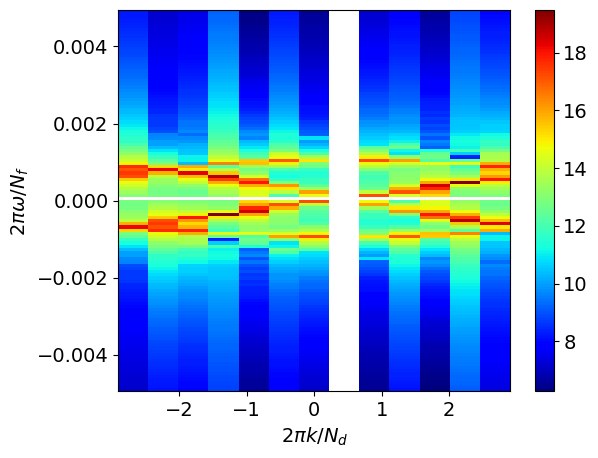

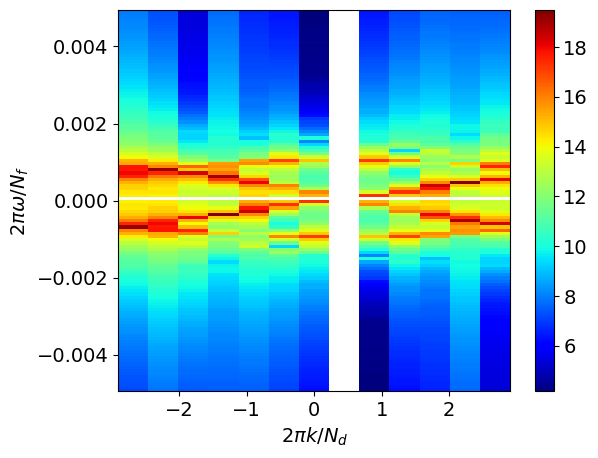

In [43]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
lst_fig = [fig1, fig2]
lst_ax = [ax1, ax2]

for group in range(2):
    ax = lst_ax[group]
    out = fft2(txy[group::2, start:ind, 1])
    N = out.shape[0]
    Nf = out.shape[1]
    out = np.log(np.abs(out)**2 / (2 * N) ** 2)
    

    out2 = np.hstack((out[:,:fft_shape], out[:,-fft_shape:]))
    # if num_particles >= 4:
    #     out2[0] = np.nan
    out2[0,0] = np.nan
    out2[:,0] = np.nan
    out2[0,:] = np.nan
    s1 = out2.shape[0]/2
    s2 = out2.shape[1]//2

    out2 = np.roll(out2, shift=int(s1), axis=0)
    out2 = np.roll(out2, shift=s2, axis=1)
    
    out2 = get_spectrum(txy[group::2, start:ind], ind=1, a=1, lim=60)
    out2 = np.log(out2 / N ** 2)

    c = ax.imshow(out2, origin='lower', aspect='auto', cmap='jet', 
#                   vmin=min_y, vmax=max_y,
                   extent=(-2 * np.pi * (s1 - 0.5 ) / N, 
                           2 * np.pi * (s1 - 0.5 ) / N, 
                           -2 * np.pi * (s2 - 0.5) / Nf,
                           2 * np.pi * (s2 - 0.5) / Nf)
                 )
    plt.colorbar(c, ax=ax)
    print(np.nanmax(out2))
    #plt.pcolormesh( out2, cmap='jet')

#     for i in range(N):
#         try:
# #             ind_max = np.nanargmax(out2[i,:s2])
#             ind_sort = np.argsort(out2[i, :s2])
#             ax.plot(2 * np.pi * (i - s1+ 0.5) / N, 2 * np.pi * (-s2 + 1 + ind_sort[-2]) / Nf, '.b')
# #             ax.plot(i-s1, -s2+ind_sort[-2], '.k', markersize=2)
            
#             ind_sort = np.argsort(out2[i, s2 +1:])
#             ax.plot(2 * np.pi * (i - s1+ 0.5) / N, 2 * np.pi * (1 + ind_sort[-1]) / Nf, '.b')
# #             ax.plot(i-s1, ind_sort[-1] + 1, '.k', markersize=2)
#         except ValueError:
#             continue

    #plt.clim((0, 20))
#     plt.colorbar()

    ax.set_xlabel('$2 \pi k / N_d $')
    ax.set_ylabel('$2 \pi \omega / N_f$')

fig1.tight_layout()
fig2.tight_layout()
if 'rad' not in folder:
    fig1.savefig(folder_pics + f'y_even_spectrum_N_{N}_W_{W}_same_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}.png', dpi=300)
    fig1.savefig(folder_pics + f'y_even_spectrum_N_{N}_W_{W}_same_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}.pdf', dpi=300)
    fig2.savefig(folder_pics + f'y_odd_spectrum_N_{N}_W_{W}_same_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}.png', dpi=300)
    fig2.savefig(folder_pics + f'y_odd_spectrum_N_{N}_W_{W}_same_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}.pdf', dpi=300)
else:
    fig1.savefig(folder_pics + f'y_even_spectrum_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}.png', dpi=300)
    fig1.savefig(folder_pics + f'y_even_spectrum_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}.pdf', dpi=300) 
    fig2.savefig(folder_pics + f'y_odd_spectrum_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}.png', dpi=300)
    fig2.savefig(folder_pics + f'y_odd_spectrum_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}.pdf', dpi=300) 

<IPython.core.display.Javascript object>


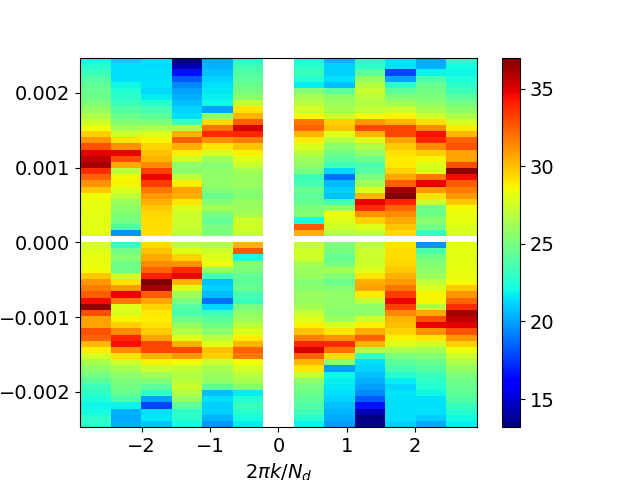

18.547600407819377
18.59800807256444


In [303]:
fig, ax = plt.subplots()
s = 0
for group in range(2):
#     ax = lst_ax[group]
    out = fft2(txy[group::2, start:ind, 1])
    N = out.shape[0]
    Nf = out.shape[1]
    out = np.log(np.abs(out)**2 / (2 * N) ** 2)
    

    out2 = np.hstack((out[:,:fft_shape], out[:,-fft_shape:]))
    # if num_particles >= 4:
    #     out2[0] = np.nan
    out2[0,0] = np.nan
    out2[:,0] = np.nan
    out2[0,:] = np.nan
    s1 = out2.shape[0]/2
    s2 = out2.shape[1]//2

    out2 = np.roll(out2, shift=int(s1), axis=0)
    out2 = np.roll(out2, shift=s2, axis=1)
    s += out2.T
    c = ax.imshow(out2.T, origin='lower', aspect='auto', cmap='jet', 
                  vmin=min_y, vmax=max_y,
                   extent=(-2 * np.pi * (s1 - 0.5 ) / N, 
                           2 * np.pi * (s1 - 0.5 ) / N, 
                           -2 * np.pi * (s2 - 0.5) / Nf,
                           2 * np.pi * (s2 - 0.5) / Nf)
                 )
    
    print(np.nanmax(out2))
    
c = ax.imshow(s, origin='lower', aspect='auto', cmap='jet', 
#               vmin=min_y, vmax=max_y,
               extent=(-2 * np.pi * (s1 - 0.5 ) / N, 
                       2 * np.pi * (s1 - 0.5 ) / N, 
                       -2 * np.pi * (s2 - 0.5) / Nf,
                       2 * np.pi * (s2 - 0.5) / Nf)
             )
plt.colorbar(c, ax=ax)
    #plt.pcolormesh( out2, cmap='jet')

#     for i in range(N):
#         try:
# #             ind_max = np.nanargmax(out2[i,:s2])
#             ind_sort = np.argsort(out2[i, :s2])
#             ax.plot(2 * np.pi * (i - s1+ 0.5) / N, 2 * np.pi * (-s2 + 1 + ind_sort[-2]) / Nf, '.b')
# #             ax.plot(i-s1, -s2+ind_sort[-2], '.k', markersize=2)
            
#             ind_sort = np.argsort(out2[i, s2 +1:])
#             ax.plot(2 * np.pi * (i - s1+ 0.5) / N, 2 * np.pi * (1 + ind_sort[-1]) / Nf, '.b')
# #             ax.plot(i-s1, ind_sort[-1] + 1, '.k', markersize=2)
#         except ValueError:
#             continue

    #plt.clim((0, 20))
#     plt.colorbar()

ax.set_xlabel('$2 \pi k / N_d $')
ax.set_ylabel('$2 \pi \omega / N_f$')

fig1.tight_layout()
fig2.tight_layout()
if 'rad' not in folder:
    fig.savefig(folder_pics + f'y_sum_odd_even_spectrum_N_{N}_W_{W}_same_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}.png', dpi=300)
    fig.savefig(folder_pics + f'y_sum_odd_even_spectrum_N_{N}_W_{W}_same_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}.pdf', dpi=300) 
else:
    fig.savefig(folder_pics + f'y_sum_odd_even_spectrum_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}.png', dpi=300)
    fig.savefig(folder_pics + f'y_sum_odd_even_spectrum_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}.pdf', dpi=300) 

# $\xi$

<IPython.core.display.Javascript object>


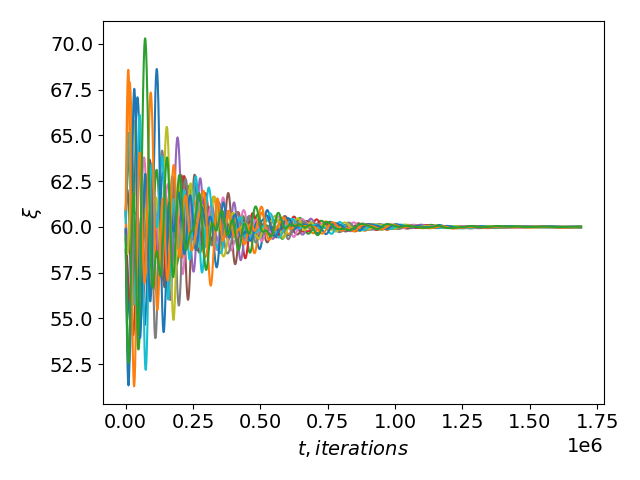

In [304]:
col = ['deepskyblue', 'mediumorchid']
fig, ax = plt.subplots()
for i in range(N):
#     ax.plot(txy[i, :, 0], txy[i, :,2], color=col[i%2])
    ax.plot(txy[i, :, 0], txy[i, :, 1])


ax.set_xlabel(r'$t, iterations$')
ax.set_ylabel(r'$\xi$')


fig.tight_layout()
if 'rad' not in folder:
    fig.savefig(folder_pics + f'time_xi_W_{W}_N_{N}_same_cy_{y0:.2f}_cs2_{cs2:.2f}_re_{reynolds:.2f}.png', dpi=300)
    fig.savefig(folder_pics + f'time_xi_W_{W}_N_{N}_same_cy_{y0:.2f}_cs2_{cs2:.2f}_re_{reynolds:.2f}.pdf', dpi=300)
else:
    fig.savefig(folder_pics + f'time_xi_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_cs2_{cs2:.2f}_re_{reynolds:.2f}.png', dpi=300)
    fig.savefig(folder_pics + f'time_xi_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_cs2_{cs2:.2f}_re_{reynolds:.2f}.pdf', dpi=300)

In [305]:
out = fft2(txy[:, start:ind, 1])
N = out.shape[0]
Nf = out.shape[1]
out = np.log(np.abs(out)**2 / N**2)

out2 = np.hstack((out[:,:fft_shape], out[:,-fft_shape:]))
# if num_particles >= 4:
#     out2[0] = np.nan
out2[0,0] = np.nan
out2[:,0] = np.nan
out2[0,:] = np.nan
s1 = out2.shape[0]/2
s2 = out2.shape[1]//2

out2 = np.roll(out2, shift=int(s1), axis=0)
out2 = np.roll(out2, shift=s2, axis=1)

min_x, max_x = np.nanmin(out2), np.nanmax(out2)

<IPython.core.display.Javascript object>


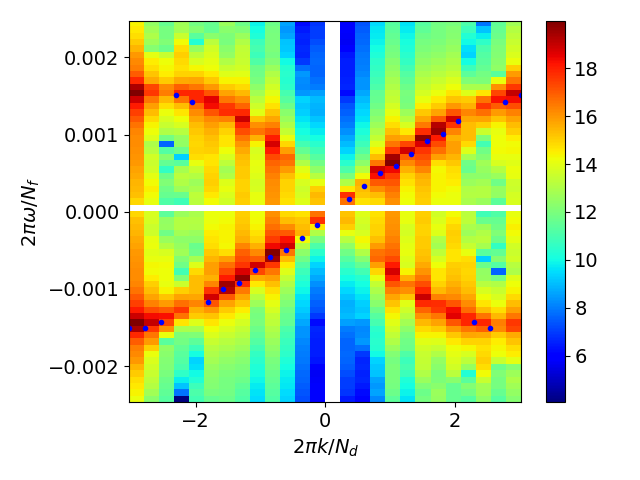

19.968163106484234


In [306]:
plt.imshow(out2.T, origin='lower', aspect='auto', cmap='jet', 
          vmin=min_x, vmax=max_x,
        extent=(-2 * np.pi * (s1 - 0.5 ) / N, 
               2 * np.pi * (s1 - 0.5 ) / N, 
               -2 * np.pi * (s2 - 0.5) / Nf,
               2 * np.pi * (s2 - 0.5) / Nf)
     )

print(np.nanmax(out2))
#plt.pcolormesh( out2, cmap='jet')

for i in range(N):
    try:
        plt.plot(2 * np.pi * (i - s1+ 0.5) / N, 2 * np.pi * (-s2 + 1 + np.nanargmax(out2[i,1:])) / Nf, '.b')
    except ValueError:
        continue
    
#plt.clim((0, 20))
plt.colorbar()
fig = plt.gcf()
ax = plt.gca()

ax.set_xlabel('$2 \pi k / N_d $')
ax.set_ylabel('$2 \pi \omega / N_f$')

fig.tight_layout()

if 'rad' not in folder:
    fig.savefig(folder_pics + f'xi_spectrum_N_{N}_W_{W}_same_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}_re_{reynolds:.2f}.png', dpi=300)
    fig.savefig(folder_pics + f'xi_spectrum_N_{N}_W_{W}_same_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}_re_{reynolds:.2f}.pdf', dpi=300)
else:
    fig.savefig(folder_pics + f'xi_spectrum_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}_re_{reynolds:.2f}.png', dpi=300)
    fig.savefig(folder_pics + f'xi_spectrum_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}_re_{reynolds:.2f}.pdf', dpi=300)    

<IPython.core.display.Javascript object>


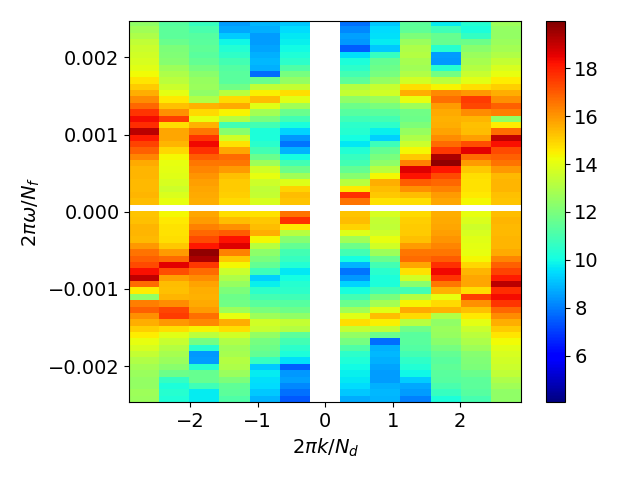

<IPython.core.display.Javascript object>


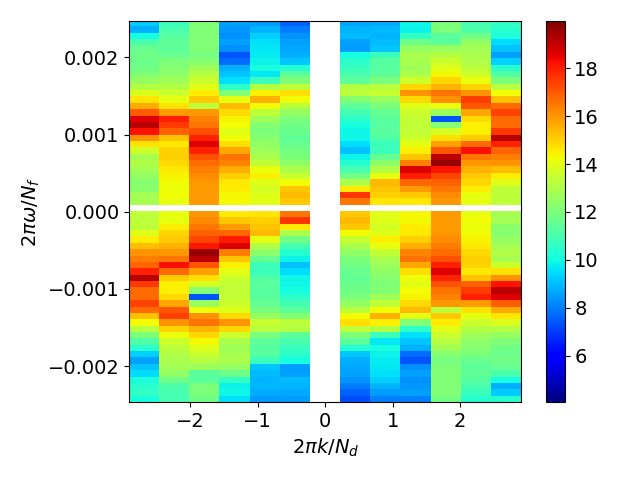

19.677358021783398
19.618512778773752


In [307]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

lst_ax = [ax1, ax2]
for group in range(2):
    ax = lst_ax[group]
    out = fft2(txy[group::2, start:ind, 3])
    N = out.shape[0]
    Nf = out.shape[1]
    out = np.log(np.abs(out)**2 / (2 * N) ** 2)

    out2 = np.hstack((out[:,:fft_shape], out[:,-fft_shape:]))
    # if num_particles >= 4:
    #     out2[0] = np.nan
    out2[0,0] = np.nan
    out2[:,0] = np.nan
    out2[0,:] = np.nan
    s1 = out2.shape[0]/2
    s2 = out2.shape[1]//2

    out2 = np.roll(out2, shift=int(s1), axis=0)
    out2 = np.roll(out2, shift=s2, axis=1)

    c = ax.imshow(out2.T, origin='lower', aspect='auto', cmap='jet',
          vmin=min_x, vmax=max_x,
        extent=(-2 * np.pi * (s1 - 0.5 ) / N, 
               2 * np.pi * (s1 - 0.5 ) / N, 
               -2 * np.pi * (s2 - 0.5) / Nf,
               2 * np.pi * (s2 - 0.5) / Nf)
     )

    plt.colorbar(c, ax=ax)
    print(np.nanmax(out2))
    #plt.pcolormesh( out2, cmap='jet')

#     for i in range(N):
#         try:
# #             ind_max = np.nanargmax(out2[i,:s2])
#             ind_sort = np.argsort(out2[i, :s2])
#             ax.plot(2 * np.pi * (i - s1+ 0.5) / N, 2 * np.pi * (-s2 + 1 + ind_sort[-2]) / Nf, '.b')
            
#             ind_sort = np.argsort(out2[i, s2 +1:])
#             ax.plot(2 * np.pi * (i - s1+ 0.5) / N, 2 * np.pi * (1 + ind_sort[-1]) / Nf, '.b')
#         except ValueError:
#             continue

    #plt.clim((0, 20))
#     plt.colorbar()

    ax.set_xlabel('$2 \pi k / N_d $')
    ax.set_ylabel('$2 \pi \omega / N_f$')

fig1.tight_layout()
fig2.tight_layout()
if 'rad' not in folder:
    fig1.savefig(folder_pics + f'xi_even_spectrum_N_{N}_W_{W}_same_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}.png', dpi=300)
    fig1.savefig(folder_pics + f'xi_even_spectrum_N_{N}_W_{W}_same_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}.pdf', dpi=300)
    fig2.savefig(folder_pics + f'xi_odd_spectrum_N_{N}_W_{W}_same_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}.png', dpi=300)
    fig2.savefig(folder_pics + f'xi_odd_spectrum_N_{N}_W_{W}_same_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}.pdf', dpi=300)
else:
    fig1.savefig(folder_pics + f'xi_even_spectrum_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}.png', dpi=300)
    fig1.savefig(folder_pics + f'xi_even_spectrum_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}.pdf', dpi=300)  
    fig2.savefig(folder_pics + f'xi_odd_spectrum_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}.png', dpi=300)
    fig2.savefig(folder_pics + f'xi_odd_spectrum_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}.pdf', dpi=300)    

# save spectrum points

20.93219195515521
16.74687114690381


/tmp/ipykernel_441541/254934724.py:11: RuntimeWarning: divide by zero encountered in log
  out = np.log(np.abs(out)**2 / N**2)


22.184103560298542
23.164317405644898
18.610297882380724
24.53597609462265


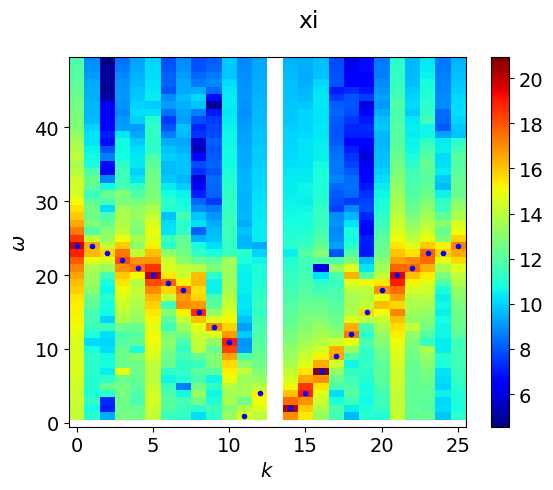

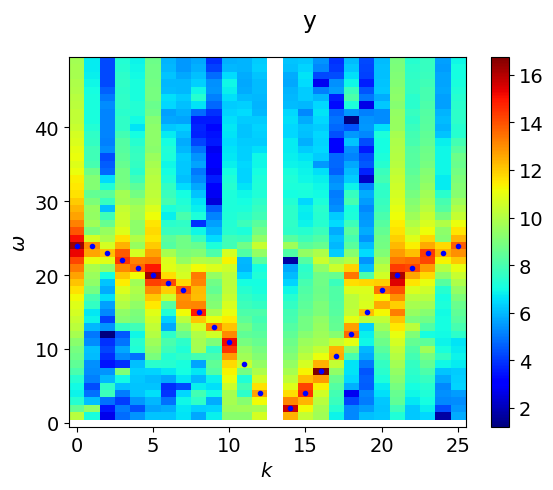

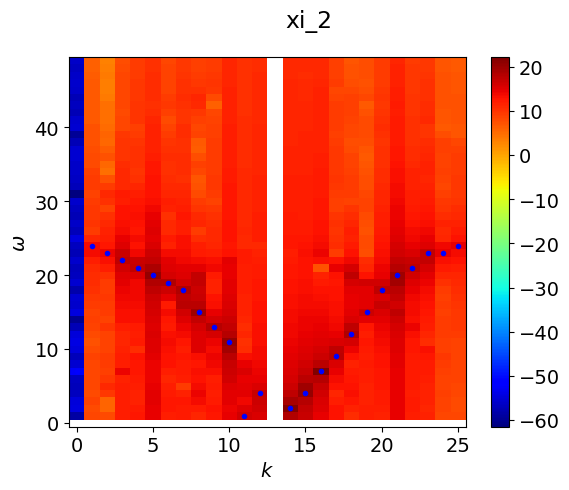

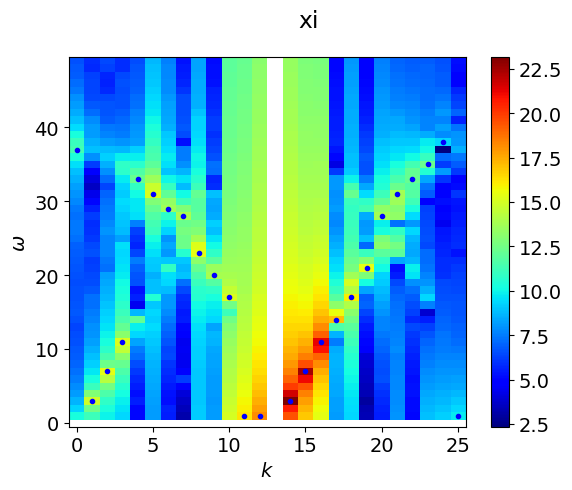

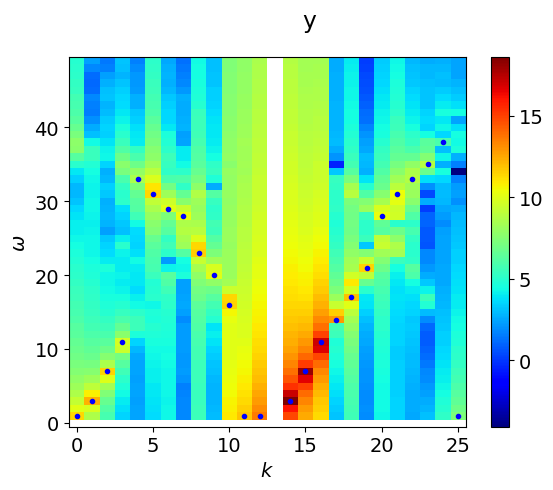

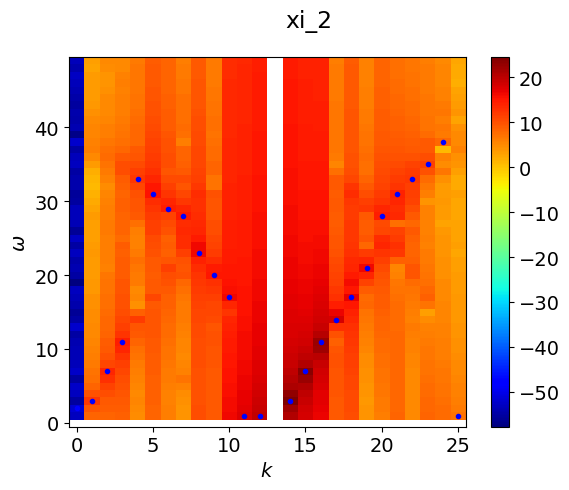

In [17]:
ind_lst = [75000, txy.shape[1]] # 
# ind = np.argmin(abs(txy[0, :, 0] - 0.5e6))
start_lst = [0, 75000]
# start = 0
axis_lst = ['xi', 'y', 'xi_2']

for i in range(len(ind_lst)):
    for j, axis in enumerate(axis_lst):
        start, ind = start_lst[i], ind_lst[i]
        out = fft2(txy[:, start:ind, j + 1])
        out = np.log(np.abs(out)**2 / N**2)

        # out2 = np.hstack((out[:,:150], out[:,-150:]))
        out2 = out[:, :50].copy()
        # if num_particles >= 4:
        #     out2[0] = np.nan
        out2[0,:] = np.nan
        out2[:,0] = np.nan
        s1 = out2.shape[0]/2
        s2 = out2.shape[1]//2

        out2 = np.roll(out2, shift=int(s1), axis=0)
        # out2 = np.roll(out2, shift=s2, axis=1)
        fig, ax = plt.subplots()
        fig.suptitle(axis)
        plt.imshow(out2.T, origin='lower', aspect='auto', cmap='jet')#, extent=(-s1-0.5, s1-0.5, -s2-0.5, s2-0.5))

        print(np.nanmax(out2))
        #plt.pcolormesh( out2, cmap='jet')
        lst = []
        for p in range(N):
            try:
                lst.append([p, 1 + np.nanargmax(out2[p,1:]), N, (ind - start) * 10])
                plt.plot(p, 1 + np.nanargmax(out2[p,1:]), '.b')
            except ValueError:
                continue

        plt.colorbar()

        ax.set_xlabel('$k$')
        ax.set_ylabel('$\omega$')  
        fig.savefig(folder[i] + f'{axis}_spectrum_{start}_{ind}.png', dpi=300)
        fig.savefig(folder[i] + f'{axis}_spectrum_{start}_{ind}.png', dpi=300)

        arr = np.array(lst)
        np.savetxt(folder + f'{axis}_points_spectrum_{start}_{ind}.txt', arr)
        #plt.clim((0, 20))

    

/tmp/ipykernel_207613/3056006042.py:5: RuntimeWarning: All-NaN slice encountered
  x, y = i - s1, np.nanmax(out2[i,1:])


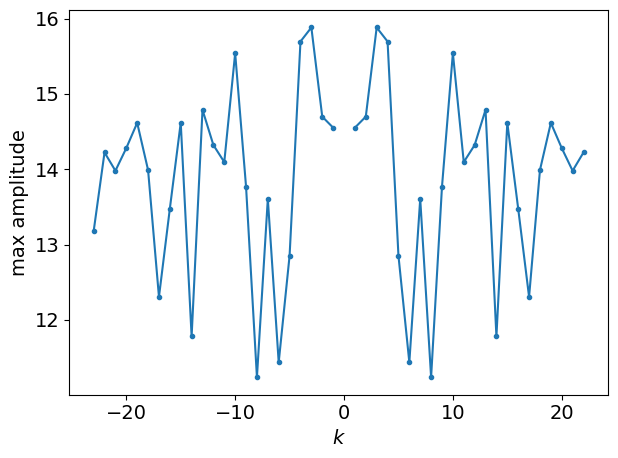

In [1036]:
fig, ax = plt.subplots()
lst = []
for i in range(N):
    try:
        x, y = i - s1, np.nanmax(out2[i,1:])
        lst.append([x, y])
    except ValueError:

        continue
    
amp = np.array(lst)
np.savetxt(folder_pics + \
           f'amp_y_spectrum_N_{N}_W_{W}_same_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}_re_{reynolds:.2f}.txt', 
          amp)
plt.plot(amp[:,0], amp[:,1], '.-')
#plt.clim((0, 20))
# plt.colorbar()

ax.set_xlabel('$k$')
ax.set_ylabel('max amplitude')

fig.tight_layout()
if 'rad' not in folder:
    fig.savefig(folder_pics + f'amp_y_spectrum_N_{N}_W_{W}_same_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}_re_{reynolds:.2f}.png', dpi=300)
    fig.savefig(folder_pics + f'amp_y_spectrum_N_{N}_W_{W}_same_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}_re_{reynolds:.2f}.pdf', dpi=300)
else:
    fig.savefig(folder_pics + f'amp_y_spectrum_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}_re_{reynolds:.2f}.png', dpi=300)
    fig.savefig(folder_pics + f'amp_y_spectrum_W_{W}_rad2_{rad2:.1f}_cy_{y0:.2f}_{start}_{ind}_cs2_{cs2:.2f}_re_{reynolds:.2f}.pdf', dpi=300)

18.572318501190107
18.35453970644399


ValueError: invalid number of data points ([13, 0]) specified

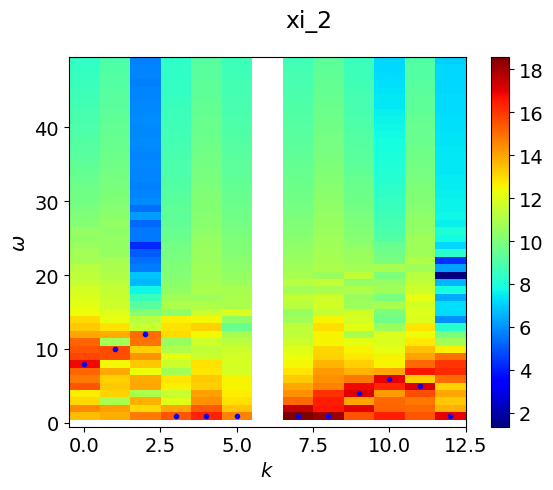

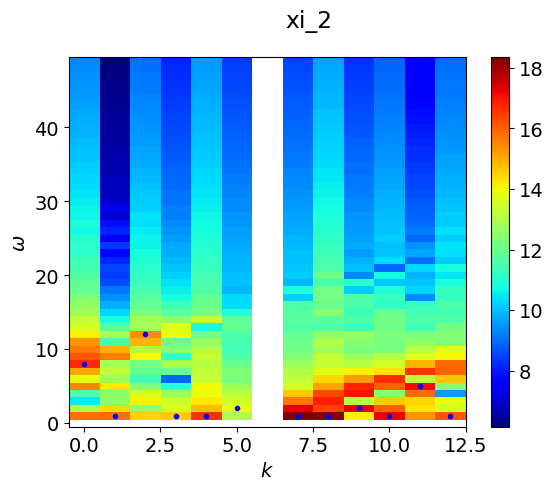

In [22]:
ind_lst = [75000, txy.shape[1]] # 
# ind = np.argmin(abs(txy[0, :, 0] - 0.5e6))
start_lst = [0, 75000]
# start = 0
axis_lst = ['xi_2']
axis = 'xi_2'

for i in range(2):
    for group in range(2):
        start, ind = start_lst[i], ind_lst[i]
        out = fft2(txy[group::2, start:ind, 3])
        out = np.log(np.abs(out)**2 / N**2)

        # out2 = np.hstack((out[:,:150], out[:,-150:]))
        out2 = out[:, :50].copy()
        # if num_particles >= 4:
        #     out2[0] = np.nan
        out2[0,:] = np.nan
        out2[:,0] = np.nan
        s1 = out2.shape[0]/2
        s2 = out2.shape[1]//2

        out2 = np.roll(out2, shift=int(s1), axis=0)
        # out2 = np.roll(out2, shift=s2, axis=1)
        fig, ax = plt.subplots()
        fig.suptitle(axis)
        plt.imshow(out2.T, origin='lower', aspect='auto', cmap='jet')#, extent=(-s1-0.5, s1-0.5, -s2-0.5, s2-0.5))

        print(np.nanmax(out2))
        #plt.pcolormesh( out2, cmap='jet')
        lst = []
        for p in range(N//2):
            try:
                lst.append([p, 1 + np.nanargmax(out2[p,1:]), N, (ind - start) * 10])
                plt.plot(p, 1 + np.nanargmax(out2[p,1:]), '.b')
            except ValueError:
                continue

        plt.colorbar()

        ax.set_xlabel('$k$')
        ax.set_ylabel('$\omega$')  
        fig.savefig(folder[i] + f'{axis}_spectrum_{start}_{ind}_even_{group}.png', dpi=300)
        fig.savefig(folder[i] + f'{axis}_spectrum_{start}_{ind}_even_{group}.png', dpi=300)

        arr = np.array(lst)
        np.savetxt(folder + f'{axis}_points_spectrum_{start}_{ind}_even_{group}.txt', arr)
        #plt.clim((0, 20))

    

In [618]:
arr = np.load(folder + 'checkpoint_fin.npy')

In [619]:
arr.shape

(9, 1040, 81)

In [575]:
v = np.array([[1, 1], [1, 0], [1, -1], [0, 1], [0, 0],\
      [0, -1], [-1, 1], [-1, 0], [-1, -1]])
t = np.array([1 / 36, 1 / 9, 1 / 36, 1 / 9, 
              4 / 9, 
              1 / 9, 1 / 36, 1 / 9, 1 / 36]) 

In [580]:
def macroscopic(fin, rho0, v, nx, ny):
    rho = np.zeros((nx, ny))#np.sum(fin, axis=0)
    u = np.zeros((2, nx, ny))
    for i in range(9):
        u[0] += v[i, 0] * fin[i]
        u[1] += v[i, 1] * fin[i]
        rho += fin[i]
    u /= rho
    return rho, u


In [620]:
rho, u = macroscopic(arr, 1, v, arr.shape[1], arr.shape[2])

<IPython.core.display.Javascript object>


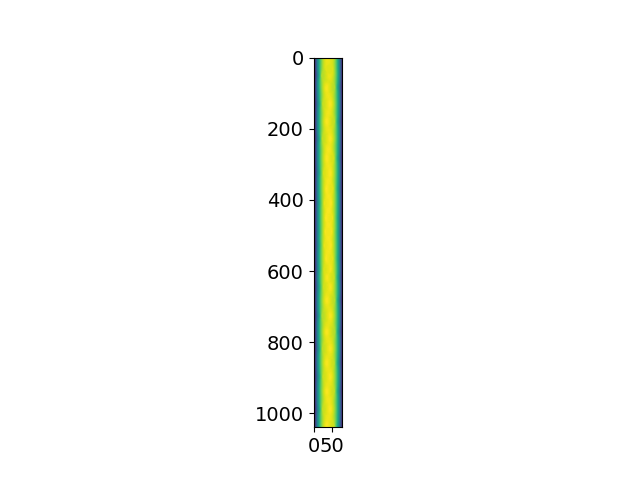

In [622]:
plt.imshow(u[0])

In [583]:
particles.shape

(26, 118696, 11)

In [623]:
ind = int((particles[0, :, 0] // 8000 * 8000)[-1] // 10)
particles[:, ind, 2].mean()

40.05411211989289

In [624]:
unorm = (u[0] ** 2 + u[1] ** 2) ** 0.5

In [599]:
%matplotlib notebook

<IPython.core.display.Javascript object>


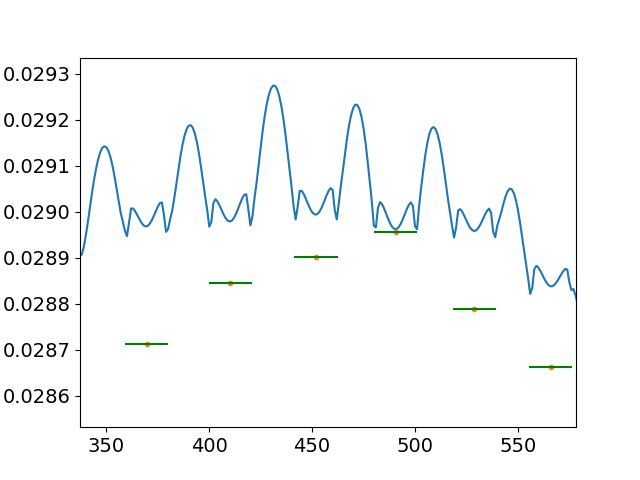

In [625]:
plt.plot(unorm[:, 40])
plt.plot(particles[:, ind, 1], (particles[:, ind, 5:7] ** 2).sum(axis=1) ** 0.5, '.')
for i in range(N):
    plt.plot([particles[i, ind, 1] - 10,
              particles[i, ind, 1] + 10], [(particles[i, ind, 5:7] ** 2).sum() ** 0.5] * 2, 'g')

<IPython.core.display.Javascript object>


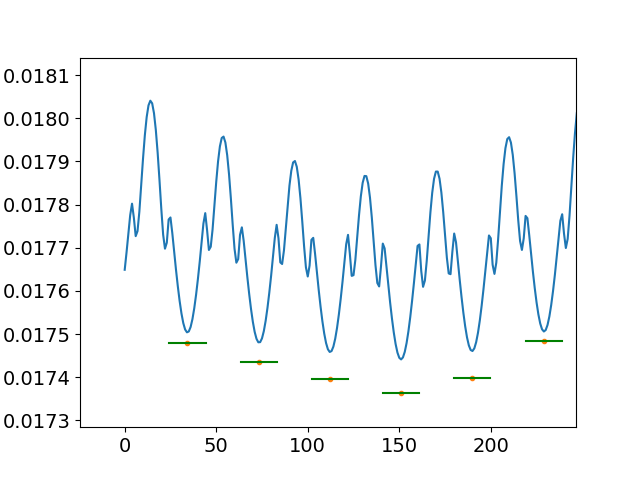

In [609]:
plt.plot(unorm[:, 61]*0.7 +unorm[:,60]*0.3)
plt.plot(particles[:, ind, 1], (particles[:, ind, 5:7] ** 2).sum(axis=1) ** 0.5, '.')
for i in range(N):
    plt.plot([particles[i, ind, 1] - 10,
              particles[i, ind, 1] + 10], [(particles[i, ind, 5:7] ** 2).sum() ** 0.5] * 2, 'g')

In [592]:
int((particles[0, :, 0] // 8000 * 8000)[-1] // 10)

118400

In [611]:
(0.0175) / 0.0180

0.9722222222222224

In [672]:



force_poiseuille = 0.4
force = np.zeros((2, nx, ny))

force[0] = force_poiseuille * (1 - np.abs(np.linspace(-1, 1, ny, endpoint=True))).reshape(1, -1) * np.ones((1, nx))

force.shape

ValueError: operands could not be broadcast together with shapes (1,5) (1,10) 

In [689]:
nx = 100
ny = 60

In [685]:
force = np.fromfunction(lambda d, x, y: (1 - d) * 0.4 * (1 - abs(0.5 - y / (ny-1))), (2, nx, ny))

In [703]:
force = np.fromfunction(lambda d, x, y: (1 - d) * 0.4 * np.sqrt(1 -  (0.5 - y / (ny-1)) ** 2), (2, nx, ny))

In [700]:
force = np.fromfunction(lambda d, x, y: (1 - d) * 0.4 * (1 - (0.5 - y / (ny-1)) ** 2) ** 0.1, (2, nx, ny))

In [701]:
force.shape

(2, 100, 60)

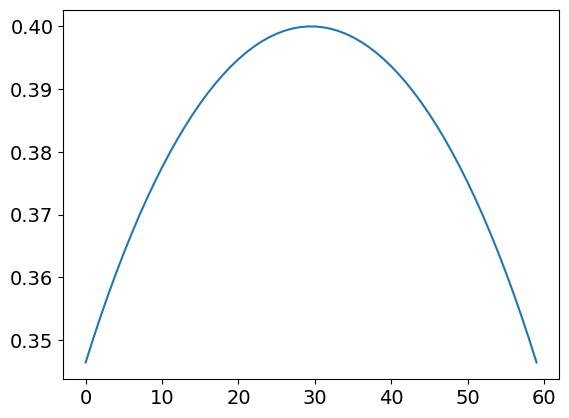

In [704]:
plt.plot(force[0, 0])

In [ ]:
np.savetxt()

In [943]:
(1/3) ** 0.5

0.5773502691896257

(-14.978426623878534, 94.99897269637516, 49.09339472989278, 81.47174310810034)

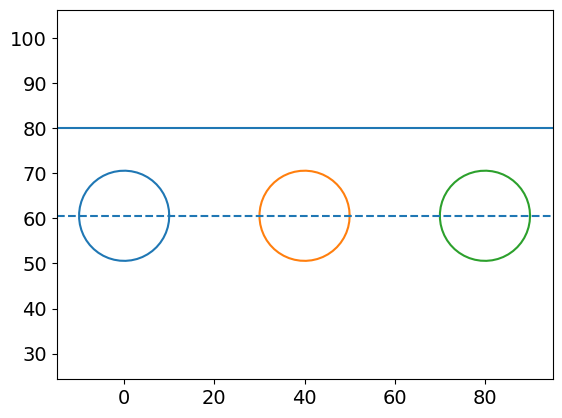

In [944]:
a = np.linspace(0, 2 * np.pi, endpoint=True)
rad = 10
x = rad * np.cos(a) 
y = rad * np.sin(a) + 60.56

x2 = rad * np.cos(a) + 4 * rad
y2 = rad * np.sin(a) + 60.56

x3 = rad * np.cos(a) + 8 * rad
y3 = rad * np.sin(a) + 60.56

fig, ax = plt.subplots()
plt.plot(x, y)
plt.plot(x2, y2)
plt.plot(x3, y3)

ax.axhline(80)
ax.axhline(60.56, linestyle='--')

plt.axis('equal')

(-14.978426623878534, 94.99897269637516, 27.505394729892778, 82.49974310810035)

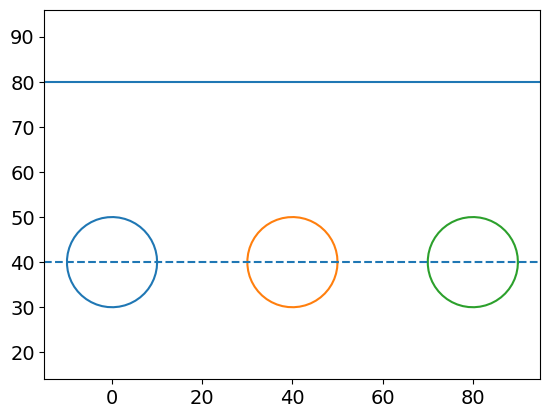

In [787]:
a = np.linspace(0, 2 * np.pi, endpoint=True)
rad = 10
cy = 40
x = rad * np.cos(a) 
y = rad * np.sin(a) + cy

x2 = rad * np.cos(a) + 4 * rad
y2 = rad * np.sin(a) + cy

x3 = rad * np.cos(a) + 8 * rad
y3 = rad * np.sin(a) + cy

fig, ax = plt.subplots()
plt.plot(x, y)
plt.plot(x2, y2)
plt.plot(x3, y3)

ax.axhline(80)
ax.axhline(cy, linestyle='--')

plt.axis('equal')

In [791]:
cs = (1 / 3) ** 0.5
cs2 = 1 / 3
vx = 0.018
vx2 = vx ** 2
y = 80 - 60.56
rad = 10

In [793]:
x = 2 * y * vx / (cs2 - vx2) ** 0.5
x

1.2127479759780875

In [794]:
x / vx

67.3748875543382

In [798]:
2 * ((x / 2) **2 + y ** 2) ** 0.5

38.89890946611792

In [795]:
a = (1 - cs2 / vx2)
b = 8 * rad
c = 16 * rad ** 2 + 4 * y **2
d = b ** 2 - 4 * a * c
d

12799115.522317695

In [796]:
x1 = (-b + d ** 0.5) / 2 / a
x2 = (-b - d ** 0.5) / 2 / a

x1, x2

(-1.701480222818851, 1.7793158790767336)

In [797]:
x2 / vx

98.85088217092965

In [799]:
2 * (((4 * rad + x2) / 2) **2 + y ** 2) ** 0.5

57.07158343101822

In [786]:
0.57 / 0.018

31.666666666666668